In [1]:
import os
from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
from torchvision import models, transforms, datasets

from PIL import Image
import matplotlib.pyplot as plt
from tqdm.auto import tqdm


In [2]:
# Adjust this if your repo root is different
REPO_ROOT = Path.cwd().parents[0] if Path.cwd().name == "notebooks" else Path.cwd()

RAW_ROOT = REPO_ROOT / "data" / "raw" / "pcb defect.v1i.yolov5pytorch"
SW_PATCH_ROOT = REPO_ROOT / "data" / "patches_sw"
RESULTS_DIR = REPO_ROOT / "results"

print("REPO_ROOT :", REPO_ROOT)
print("RAW_ROOT  :", RAW_ROOT)
print("SW_ROOT   :", SW_PATCH_ROOT)
print("RESULTS   :", RESULTS_DIR)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


REPO_ROOT : C:\Users\amrik\Data Science\Personal-PCB-Project
RAW_ROOT  : C:\Users\amrik\Data Science\Personal-PCB-Project\data\raw\pcb defect.v1i.yolov5pytorch
SW_ROOT   : C:\Users\amrik\Data Science\Personal-PCB-Project\data\patches_sw
RESULTS   : C:\Users\amrik\Data Science\Personal-PCB-Project\results
Using device: cuda


In [3]:
PATCH_SIZE = 128

CLASSES = [
    "background",
    "missing_hole",
    "mouse_bite",
    "open_circuit",
    "short",
    "spur",
    "spurious_copper",
]

# Inference / eval transform (no augmentation)
inference_transform = transforms.Compose([
    transforms.Resize((PATCH_SIZE, PATCH_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],   # ImageNet mean
        std=[0.229, 0.224, 0.225],    # ImageNet std
    ),
])

# Patch dataset from the sliding-window patches (test split)
test_patch_dir = SW_PATCH_ROOT / "test"
test_dataset = datasets.ImageFolder(
    root=test_patch_dir,
    transform=inference_transform
)
print("Test patch dataset size:", len(test_dataset))
print("Classes in ImageFolder:", test_dataset.classes)


Test patch dataset size: 7787
Classes in ImageFolder: ['background', 'missing_hole', 'mouse_bite', 'open_circuit', 'short', 'spur', 'spurious_copper']


In [4]:
num_classes = len(CLASSES)

# Build same architecture as training
model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
model = model.to(device)

# Load weights
ckpt_path = RESULTS_DIR / "mobilenetv2_sw_best.pth"
print("Loading checkpoint:", ckpt_path)
state = torch.load(ckpt_path, map_location=device)
model.load_state_dict(state)
model.eval()

print("Model loaded and in eval mode.")


Loading checkpoint: C:\Users\amrik\Data Science\Personal-PCB-Project\results\mobilenetv2_sw_best.pth
Model loaded and in eval mode.


In [5]:
def predict_patch(pil_img):
    """Take a PIL patch, run through model, return probs & predicted class."""
    model.eval()
    with torch.no_grad(), torch.amp.autocast(device_type=device.type, dtype=torch.float16, enabled=(device.type=="cuda")):
        x = inference_transform(pil_img).unsqueeze(0).to(device)
        logits = model(x)
        probs = torch.softmax(logits, dim=1)[0].cpu().numpy()
    pred_idx = int(np.argmax(probs))
    return pred_idx, probs


def show_patch_with_prediction(pil_img, true_label=None):
    pred_idx, probs = predict_patch(pil_img)
    pred_label = CLASSES[pred_idx]

    plt.figure(figsize=(3,3))
    plt.imshow(pil_img)
    plt.axis("off")
    title = f"Pred: {pred_label}"
    if true_label is not None:
        title = f"True: {true_label} | " + title
    plt.title(title)
    plt.show()

    print("Top class probabilities:")
    for cls, p in sorted(zip(CLASSES, probs), key=lambda x: x[1], reverse=True):
        print(f"  {cls:15s} : {p:0.3f}")


Random test patch index: 4127
File: C:\Users\amrik\Data Science\Personal-PCB-Project\data\patches_sw\test\missing_hole\06_missing_hole_04_jpg.rf.428a916a295df5adc4893b54535ddba4_x192_y288.jpg


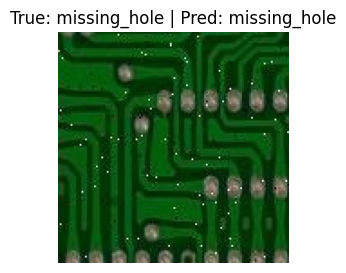

Top class probabilities:
  missing_hole    : 1.000
  background      : 0.000
  mouse_bite      : 0.000
  open_circuit    : 0.000
  spurious_copper : 0.000
  spur            : 0.000
  short           : 0.000


In [13]:
import random
from PIL import Image

idx = random.randint(0, len(test_dataset) - 1)

img_path, label_idx = test_dataset.samples[idx]   # path + class index
patch_pil = Image.open(img_path).convert("RGB")   # true RGB pixels
true_label = CLASSES[label_idx]

print("Random test patch index:", idx)
print("File:", img_path)

show_patch_with_prediction(patch_pil, true_label=true_label)


In [14]:
def iou(box1, box2):
    # boxes: [x1, y1, x2, y2]
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    inter_w = max(0.0, x2 - x1)
    inter_h = max(0.0, y2 - y1)
    inter = inter_w * inter_h
    if inter == 0:
        return 0.0

    area1 = (box1[2]-box1[0]) * (box1[3]-box1[1])
    area2 = (box2[2]-box2[0]) * (box2[3]-box2[1])
    union = area1 + area2 - inter
    return inter / union


def nms(detections, iou_thresh=0.3):
    """
    detections: list of (x1, y1, x2, y2, cls_idx, prob)
    returns: pruned list
    """
    if not detections:
        return []

    dets = sorted(detections, key=lambda d: d[5], reverse=True)
    kept = []

    while dets:
        best = dets.pop(0)
        kept.append(best)
        remaining = []
        for d in dets:
            if iou(best[:4], d[:4]) < iou_thresh:
                remaining.append(d)
        dets = remaining

    return kept


In [15]:
def run_sliding_window_on_image(img_pil,
                                window_size=PATCH_SIZE,
                                stride=None,
                                prob_thresh=0.6):
    """
    Returns list of detections: (x1, y1, x2, y2, cls_idx, prob)
    """
    if stride is None:
        stride = window_size // 2  # 50% overlap

    W, H = img_pil.size
    detections = []

    # move over the image
    for y in range(0, H - window_size + 1, stride):
        for x in range(0, W - window_size + 1, stride):
            patch = img_pil.crop((x, y, x+window_size, y+window_size))
            pred_idx, probs = predict_patch(patch)

            prob = float(probs[pred_idx])
            # skip background or low-confidence
            if CLASSES[pred_idx] == "background":
                continue
            if prob < prob_thresh:
                continue

            detections.append((x, y, x+window_size, y+window_size, pred_idx, prob))

    return detections


In [16]:
def visualize_detections(full_img_pil, detections, title="Detections"):
    plt.figure(figsize=(6,6))
    plt.imshow(full_img_pil)
    ax = plt.gca()
    for (x1, y1, x2, y2, cls_idx, prob) in detections:
        w = x2 - x1
        h = y2 - y1
        rect = plt.Rectangle(
            (x1, y1), w, h,
            fill=False, linewidth=2
        )
        ax.add_patch(rect)
        label = f"{CLASSES[cls_idx]}: {prob:.2f}"
        ax.text(x1, y1-3, label,
                fontsize=8,
                color="yellow",
                bbox=dict(facecolor="black", alpha=0.5, pad=1))
    plt.axis("off")
    plt.title(title)
    plt.show()


In [35]:
def intersection_box(b1, b2):
    x1 = max(b1[0], b2[0])
    y1 = max(b1[1], b2[1])
    x2 = min(b1[2], b2[2])
    y2 = min(b1[3], b2[3])
    if x2 <= x1 or y2 <= y1:
        return None  # no overlap
    return (x1, y1, x2, y2)


def merge_by_any_intersection(dets):
    """
    dets: list of (x1, y1, x2, y2, cls_idx, prob)
    If two boxes of the same class intersect at all, replace them
    with their intersection box (prob = max of the pair).
    Repeat until no more merges.
    """
    dets = dets.copy()
    changed = True

    while changed:
        changed = False
        new_dets = []
        used = set()

        for i in range(len(dets)):
            if i in used:
                continue

            box_i = dets[i]
            merged_box = box_i

            for j in range(i + 1, len(dets)):
                if j in used:
                    continue

                box_j = dets[j]

                # only merge boxes of same class
                if box_i[4] != box_j[4]:
                    continue

                inter = intersection_box(box_i, box_j)
                if inter is not None:
                    # take intersection, keep max prob
                    new_prob = max(box_i[5], box_j[5])
                    merged_box = (inter[0], inter[1], inter[2], inter[3], box_i[4], new_prob)
                    used.add(j)
                    changed = True

            new_dets.append(merged_box)
            used.add(i)

        dets = new_dets

    return dets


Using image: C:\Users\amrik\Data Science\Personal-PCB-Project\data\raw\pcb defect.v1i.yolov5pytorch\train\images\01_missing_hole_01_jpg.rf.048b220b403c2678f1a9f40f5bb3a8eb.jpg
Image size: (640, 640)
Detections after NMS: 6
Raw detections (before NMS): 12
Detections after NMS: 6
Detections after intersection merge: 3


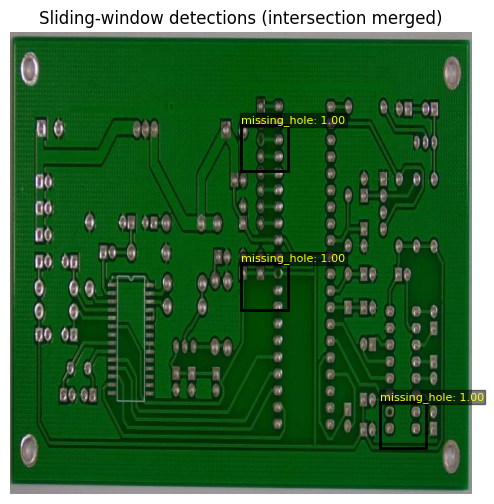

In [41]:
# Example: use a missing-hole image from RAW train split
full_img_dir = RAW_ROOT / "train" / "images"

# You can choose a specific file if you want:
# img_path = full_img_dir / "01_missing_hole_01_jpg.rf....jpg"
img_path = sorted(full_img_dir.glob("*.jpg"))[0]  # just first one for now

print("Using image:", img_path)

full_img = Image.open(img_path).convert("RGB")
print("Image size:", full_img.size)

# Run sliding window
raw_dets = run_sliding_window_on_image(
    full_img,
    window_size=PATCH_SIZE,
    stride=PATCH_SIZE//2,
    prob_thresh=0.6
)

# NMS
final_dets = nms(raw_dets, iou_thresh=0.3)
print("Detections after NMS:", len(final_dets))

print("Raw detections (before NMS):", len(raw_dets))

dets_nms = nms(raw_dets, iou_thresh=0.3)
print("Detections after NMS:", len(dets_nms))

merged_dets = merge_by_any_intersection(dets_nms)
print("Detections after intersection merge:", len(merged_dets))

visualize_detections(full_img, merged_dets,
                     title="Sliding-window detections (intersection merged)")


In [43]:
from torchvision import datasets, transforms

PATCH_SIZE = 128  # same as training

test_transform = transforms.Compose([
    transforms.Resize((PATCH_SIZE, PATCH_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

SW_PATCH_ROOT = REPO_ROOT / "data" / "patches_sw"   # or whatever you used

test_dataset = datasets.ImageFolder(
    root=SW_PATCH_ROOT / "test",
    transform=test_transform
)

from torch.utils.data import DataLoader

test_loader = DataLoader(
    test_dataset,
    batch_size=128,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

print("Test size:", len(test_dataset))


Test size: 7787


In [45]:
from torch.utils.data import DataLoader

BATCH_SIZE = 256   # 256 or 512 should be fine on your GPU

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,          # <- IMPORTANT on Windows / Jupyter
    pin_memory=True
)


In [46]:
import torch
import numpy as np
from tqdm.auto import tqdm
from sklearn.metrics import confusion_matrix, classification_report

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

def evaluate_on_loader(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, targets in tqdm(loader, desc="Eval", leave=False):
            inputs = inputs.to(device, non_blocking=True)
            targets = targets.to(device, non_blocking=True)

            # mixed precision on GPU
            with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):
                outputs = model(inputs)

            preds = outputs.argmax(dim=1)

            correct += (preds == targets).sum().item()
            total += targets.size(0)

            all_labels.append(targets.cpu())
            all_preds.append(preds.cpu())

    acc = correct / total
    all_labels = torch.cat(all_labels).numpy()
    all_preds = torch.cat(all_preds).numpy()
    return acc, all_labels, all_preds

# ---- run on test set ----
test_acc, y_true, y_pred = evaluate_on_loader(model, test_loader, device)
print(f"\nPatch-level TEST accuracy: {test_acc:.4f}")


Eval:   0%|          | 0/31 [00:00<?, ?it/s]

C:\Users\amrik\AppData\Local\Temp\ipykernel_62932\3235604537.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):



Patch-level TEST accuracy: 0.8473
